In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/cycl_m.csv", index_col=0)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')
num = 12


df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry,year,month,quarter,season,month_sin,month_cos,quarter_sin,quarter_cos,season_sin,season_cos
Date,,,,,,,,,,,,,,,
2009-01-31,0.032915,0.216100,0.068714,0.726750,0.396506,2009,1,1,1,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2009-02-28,0.073145,0.296982,0.074975,0.936674,0.508567,2009,2,1,1,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2009-03-31,0.178683,0.356360,0.236094,0.627008,0.469107,2009,3,1,2,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17,1.224647e-16,-1.000000e+00
2009-04-30,0.085162,0.410094,0.413676,0.693265,0.407926,2009,4,2,2,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00
2009-05-31,0.149425,0.428197,0.647873,0.400633,0.201392,2009,5,2,2,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29,0.097179,0.583554,0.225748,0.736863,0.420133,2020,2,1,1,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2020-03-31,0.366771,0.605731,0.255726,0.721515,0.632459,2020,3,1,2,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17,1.224647e-16,-1.000000e+00
2020-04-30,0.217346,0.615560,0.421868,0.896287,0.475913,2020,4,2,2,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00


In [72]:
features_cos = ['Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry', 'day_cos', 'month_cos', 'week_of_year_cos', 'quarter_cos', 'season_cos']
delete2 = [feature for feature in df.columns if feature not in features_cos]
df_cos = df.drop(delete2, axis=1)
features_new = ['Depth_to_Groundwater', 'Drainage_Volume', 'River_Hydrometry']
delete3 = [feature for feature in df_cos.columns if feature not in features_new]
df = df_cos.drop(delete3, axis=1)

target = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in target]

In [73]:
features

['Drainage_Volume', 'River_Hydrometry']

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

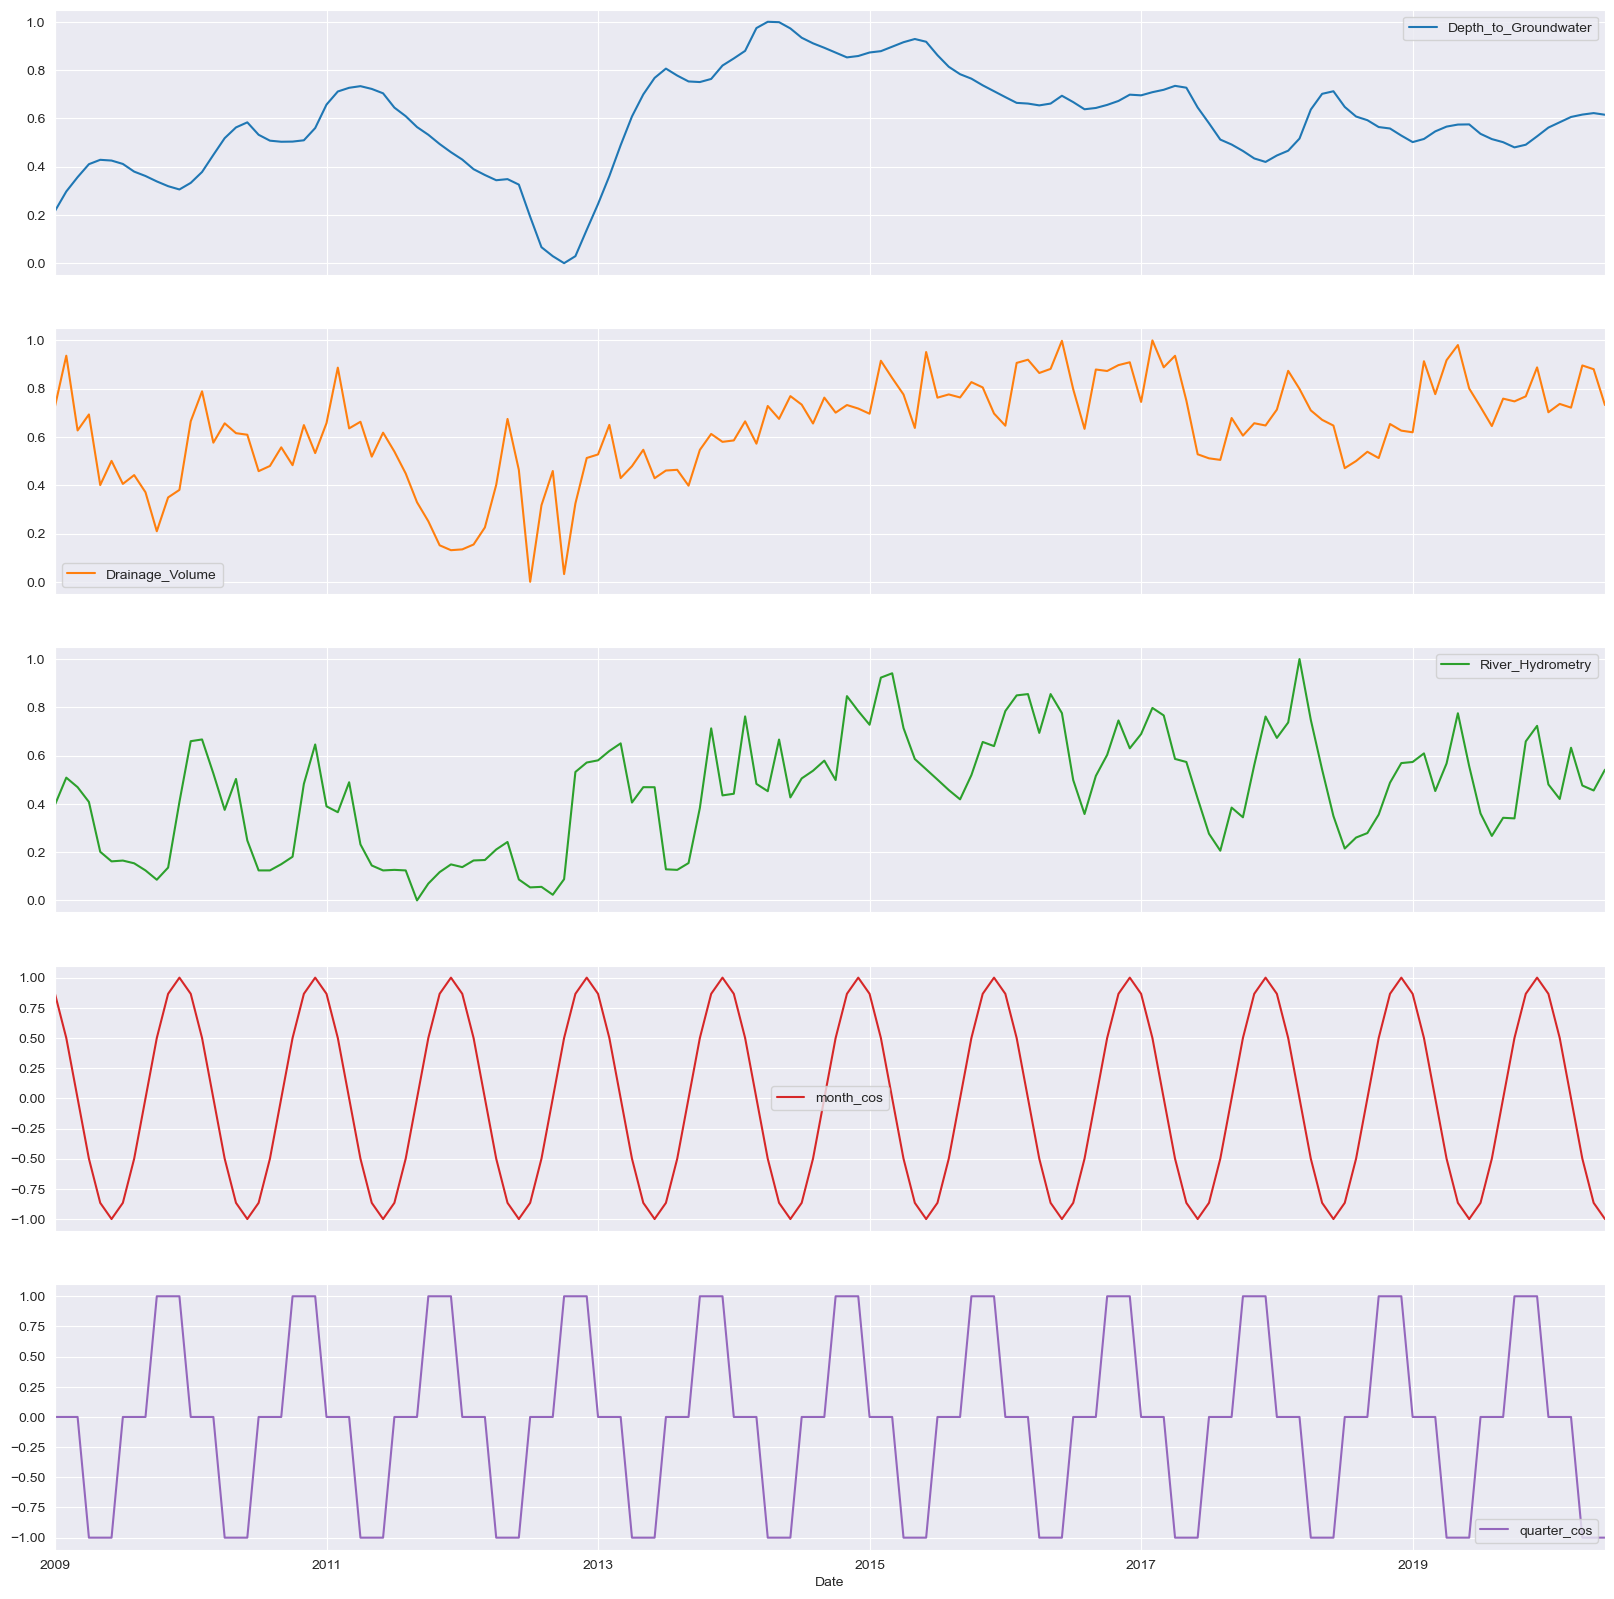

In [11]:
df.plot(subplots=True, figsize=(20, 20))

In [74]:
def split_data():
    testSize = int(0.3 * len(df))
    train= df.iloc[:-testSize]
    test= df.iloc[-testSize:]
    return train, test
train, test = split_data()

In [54]:
testSize = int(0.3 * len(df))
testSize

41

In [75]:
# Find the optimal ARIMAX model order using auto_arima
auto_model = auto_arima(
    train[target],
    exogenous=train[features],
    seasonal=False,  # Set to True for seasonal data
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    max_order=None,  # You can limit the search space for orders
    trace=True
)

# Get the selected order
order = auto_model.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-407.424, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-309.345, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-401.909, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-386.064, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-310.282, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-408.564, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-397.239, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-409.836, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-408.372, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-408.691, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-411.507, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-387.261, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-403.615, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-409.931, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [8]:
order

(1, 1, 1)

In [13]:
#open text file
text_file = open("C:\\Users\\poeppelmann\\DataspellProjects\\dsProject\\order\\ARIMAX_order_"+str(num)+".txt", "w")

#write string to file
text_file.write(str(order))

#close file
text_file.close()

In [15]:
def fit_arimax(df):
    model = ARIMA(endog=df[target], exog=df[features], order=order)
    model=model.fit()
    return model

In [16]:
model = fit_arimax(train)
predictions = model.predict(start=test.index[0], end=test.index[-1], exog=test[features])

<Axes: xlabel='Date'>

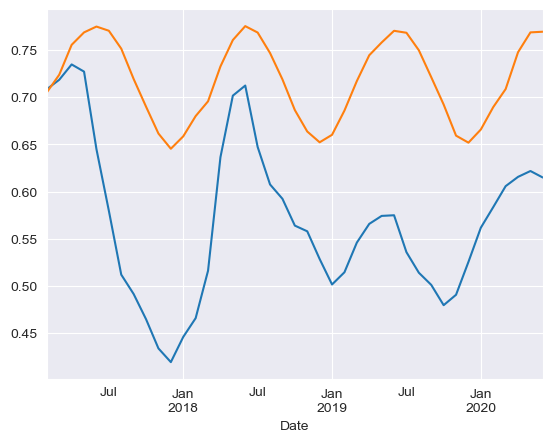

In [18]:

test['Depth_to_Groundwater'].plot(label=True)
predictions.plot(label=True)

In [37]:
# Rolling ARIMA algorithm
def arimax_roll():
    history = train.copy()
    predictions = pd.Series()

    for t in range(len(test)):
        model = fit_arimax(history)
        hat = model.forecast(steps=1, exog=history[features].iloc[[-1]])  # Forecast one step ahead
        predictions = predictions.append(hat)

        # Update history and exogenous history for the next iteration
        history = history.append(test.iloc[t])
    return predictions

In [76]:
predictions = arimax_roll()

In [77]:
predictions

2017-02-28    0.692442
2017-03-31    0.722687
2017-04-30    0.725040
2017-05-31    0.740114
2017-06-30    0.720593
2017-07-31    0.553816
2017-08-31    0.539194
2017-09-30    0.451540
2017-10-31    0.493824
2017-11-30    0.437193
2017-12-31    0.417734
2018-01-31    0.417813
2018-02-28    0.469181
2018-03-31    0.476924
2018-04-30    0.577347
2018-05-31    0.734785
2018-06-30    0.728476
2018-07-31    0.706130
2018-08-31    0.579404
2018-09-30    0.590989
2018-10-31    0.582057
2018-11-30    0.542100
2018-12-31    0.561036
2019-01-31    0.501491
2019-02-28    0.483505
2019-03-31    0.526604
2019-04-30    0.571603
2019-05-31    0.578018
2019-06-30    0.586022
2019-07-31    0.567386
2019-08-31    0.491372
2019-09-30    0.505913
2019-10-31    0.490691
2019-11-30    0.461399
2019-12-31    0.521328
2020-01-31    0.549389
2020-02-29    0.586209
2020-03-31    0.593701
2020-04-30    0.634150
2020-05-31    0.604663
2020-06-30    0.631593
Freq: M, dtype: float64

<Axes: xlabel='Date'>

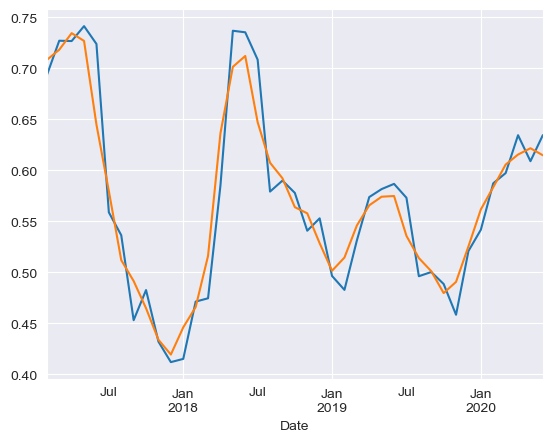

In [58]:
predictions.plot()
test['Depth_to_Groundwater'].plot()

In [45]:
predictions.name = 'Depth_to_Groundwater'
predictions.to_csv('predictions/ARIMAX/'+str(num)+'.csv')

In [46]:
saved_sr = pd.read_csv('./predictions/ARIMA/'+str(num)+'.csv', index_col=0)
saved_sr.index = pd.to_datetime(saved_sr.index, format = '%Y-%m-%d')

FileNotFoundError: [Errno 2] No such file or directory: './predictions/ARIMA/12.csv'

In [78]:
saved_sr = predictions

In [79]:
metrics = {}
def calc_metrics():

    results = pd.DataFrame(data={'Predictions':saved_sr, 'Actuals':df['Depth_to_Groundwater']}, index=saved_sr.index)

    # Step 2: Calculate the differences between the predicted and actual values
    results['Difference'] = results['Actuals'] - results['Predictions']

    # Step 3: Calculate squared differences for RMSE
    results['Squared_difference'] = results['Difference'] ** 2

    # Step 4: Calculate absolute differences for MAE and MAPE
    results['Absolute_difference'] = np.abs(results['Difference'])
    results['Absolute_percentage_difference'] = np.abs(results['Difference'] / results['Actuals'])

    # Step 5: Compute the metrics
    rmse = np.sqrt(results['Squared_difference'].mean())
    mae = results['Absolute_difference'].mean()
    mape = results['Absolute_percentage_difference'].mean() * 100  # to get the percentage
    return rmse, mae, mape

rmse, mae, mape = calc_metrics()
metrics['Depth_to_Groundwater'] = {
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}
metrics_df = pd.DataFrame(metrics)

In [80]:
metrics_df

,Depth_to_Groundwater
MAE,0.020338
MAPE,3.579005
RMSE,0.026359


In [ ]:
metrics_df.to_csv('metrics/ARIMAX/'+str(num)+'.csv')

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

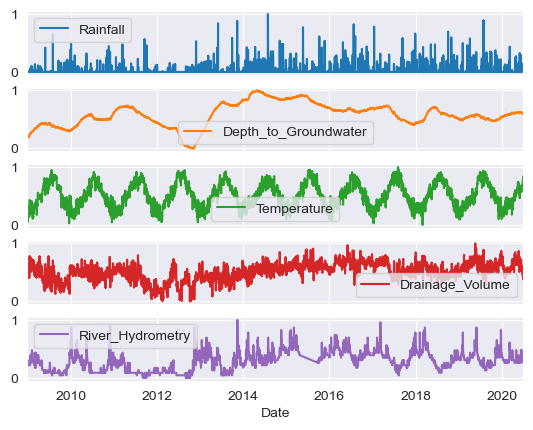

In [50]:
df.plot(subplots=True)